In [50]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("atalaydenknalbant/rawg-games-dataset")

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
df = ds["train"].to_pandas()

In [53]:
df.head()

,id,slug,name,released,background_image,rating,rating_top,ratings_count,reviews_text_count,added,...,achievements_count,alternative_names,parent_achievements_count,game_series_count,additions_count,movies_count,reddit_name,reddit_description,reddit_logo,tba
0,19103,half-life-2-lost-coast,Half-Life 2: Lost Coast,2005-10-27,https://media.rawg.io/media/games/b7b/b7b83817...,3.45,4.0,1164.0,3.0,11676.0,...,NaN,nan,NaN,NaN,NaN,NaN,nan,nan,nan,NaN
1,12020,left-4-dead-2,Left 4 Dead 2,2009-11-17,https://media.rawg.io/media/games/d58/d588947d...,4.09,4.0,3355.0,25.0,17398.0,...,166.0,L4D2,102.0,2.0,NaN,NaN,nan,nan,nan,NaN
2,13536,portal,Portal,2007-10-09,https://media.rawg.io/media/games/7fa/7fa0b586...,4.49,5.0,4896.0,44.0,17582.0,...,15.0,ポータル|포털,15.0,3.0,4.0,NaN,nan,nan,nan,NaN
3,3272,rocket-league,Rocket League,2015-07-07,https://media.rawg.io/media/games/8cc/8cce7c0e...,3.93,4.0,2827.0,22.0,12787.0,...,430.0,nan,94.0,1.0,3.0,NaN,nan,nan,nan,NaN
4,3439,life-is-strange-episode-1-2,Life is Strange,2015-01-29,https://media.rawg.io/media/games/562/56255381...,4.12,5.0,3717.0,47.0,15788.0,...,607.0,LiS|Life is Strange Complete Season,61.0,5.0,6.0,NaN,nan,nan,nan,NaN


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889793 entries, 0 to 889792
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           889793 non-null  int64  
 1   slug                         889793 non-null  object 
 2   name                         889793 non-null  object 
 3   released                     889793 non-null  object 
 4   background_image             889793 non-null  object 
 5   rating                       18109 non-null   float64
 6   rating_top                   20078 non-null   float64
 7   ratings_count                57839 non-null   float64
 8   reviews_text_count           9471 non-null    float64
 9   added                        109395 non-null  float64
 10  playtime                     33286 non-null   float64
 11  suggestions_count            850510 non-null  float64
 12  updated                      889793 non-null  object 
 13 

In [55]:
df.isnull().sum().sort_values(ascending=False)

clip                           889793
additions_count                888022
reddit_count                   887958
tba                            887125
parents_count                  886502
metacritic                     882663
reviews_text_count             880322
twitch_count                   879943
game_series_count              879144
youtube_count                  878588
movies_count                   876901
creators_count                 874569
rating                         871684
rating_top                     869715
parent_achievements_count      861092
achievements_count             861069
playtime                       856507
ratings_count                  831954
reviews_count                  830532
added                          780398
suggestions_count               39283
screenshots_count               27978
website                             0
alternative_names                   0
reddit_description                  0
description_raw                     0
description 

In [56]:
df.replace(['NaN', 'nan', 'None'], np.nan, inplace=True)

In [57]:
# Added: id, slug, developers, description
df = df[["id", "slug", "name", "description", "developers", "genres", "tags", "rating", "ratings_count", "reviews_count" , "added", "playtime", "metacritic", "parent_platforms", "esrb_rating", "released", "background_image","suggestions_count"]]

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889793 entries, 0 to 889792
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 889793 non-null  int64  
 1   slug               889792 non-null  object 
 2   name               889791 non-null  object 
 3   description        888324 non-null  object 
 4   developers         889786 non-null  object 
 5   genres             889793 non-null  object 
 6   tags               889792 non-null  object 
 7   rating             18109 non-null   float64
 8   ratings_count      57839 non-null   float64
 9   reviews_count      59261 non-null   float64
 10  added              109395 non-null  float64
 11  playtime           33286 non-null   float64
 12  metacritic         7130 non-null    float64
 13  parent_platforms   889793 non-null  object 
 14  esrb_rating        70668 non-null   object 
 15  released           860336 non-null  object 
 16  ba

In [59]:
df.isnull().sum().sort_values(ascending=False)

metacritic           882663
rating               871684
playtime             856507
ratings_count        831954
reviews_count        830532
esrb_rating          819125
added                780398
suggestions_count     39283
released              29457
background_image      27394
description            1469
developers                7
name                      2
tags                      1
slug                      1
genres                    0
parent_platforms          0
id                        0
dtype: int64

In [60]:
df.dropna(subset=['name', 'genres', 'rating'], axis=0, inplace=True)

In [61]:
df.isnull().sum().sort_values(ascending=False)

metacritic           12294
esrb_rating          10586
playtime              5755
released               389
suggestions_count       96
description             90
background_image        82
ratings_count            1
added                    0
parent_platforms         0
id                       0
slug                     0
rating                   0
tags                     0
genres                   0
developers               0
name                     0
reviews_count            0
dtype: int64

In [62]:
df.dropna(subset=['suggestions_count','ratings_count'], axis=0, inplace=True)

In [63]:
df = df.drop(columns=['metacritic','esrb_rating'])

In [64]:
df = df[df["playtime"].notnull()]

In [65]:
df = df[df["released"].notnull()]

In [66]:
df = df[df["background_image"].notnull()]

In [67]:
df = df[df["description"].notnull()]

In [68]:
# Save the cleaned dataframe to a new CSV
df.to_csv("game_recommendation_cleaned.csv", index=False)

In [69]:
df.isnull().sum().sort_values(ascending=False)

id                   0
slug                 0
name                 0
description          0
developers           0
genres               0
tags                 0
rating               0
ratings_count        0
reviews_count        0
added                0
playtime             0
parent_platforms     0
released             0
background_image     0
suggestions_count    0
dtype: int64

In [70]:
# 1. Clean the HTML out of the descriptions
import re
def clean_html(text):
    if not text: return ""
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower() # Remove special chars
    return text

df['clean_description'] = df['description'].apply(clean_html)

# 2. Vectorize the text (This creates the "math" version of your descriptions)
# Note: TfidfVectorizer was already imported in your Cell 32
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['clean_description'])
tfidf_matrix = tfidf_matrix.tocsr()

print("NLP Vectorization Complete. Matrix shape:", tfidf_matrix.shape)

NLP Vectorization Complete. Matrix shape: (11970, 5000)


In [71]:
df.describe()

,id,rating,ratings_count,reviews_count,added,playtime,suggestions_count
count,1.197000e+04,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000
mean,1.364385e+05,3.218886,122.785798,124.277694,909.707853,4.867836,373.097744
std,2.429495e+05,0.751006,344.329530,348.382522,1626.441840,20.374079,176.400951
min,1.000000e+00,1.000000,4.000000,6.000000,10.000000,1.000000,2.000000
25%,1.219475e+04,2.710000,11.000000,11.000000,164.000000,1.000000,241.000000
50%,2.066050e+04,3.330000,24.000000,25.000000,359.000000,3.000000,368.000000
75%,6.017875e+04,3.820000,77.000000,78.000000,901.000000,4.000000,498.000000
max,1.003458e+06,5.000000,7153.000000,7268.000000,22126.000000,1473.000000,1729.000000


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11970 entries, 0 to 41791
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 11970 non-null  int64  
 1   slug               11970 non-null  object 
 2   name               11970 non-null  object 
 3   description        11970 non-null  object 
 4   developers         11970 non-null  object 
 5   genres             11970 non-null  object 
 6   tags               11970 non-null  object 
 7   rating             11970 non-null  float64
 8   ratings_count      11970 non-null  float64
 9   reviews_count      11970 non-null  float64
 10  added              11970 non-null  float64
 11  playtime           11970 non-null  float64
 12  parent_platforms   11970 non-null  object 
 13  released           11970 non-null  object 
 14  background_image   11970 non-null  object 
 15  suggestions_count  11970 non-null  float64
 16  clean_description  11970 no

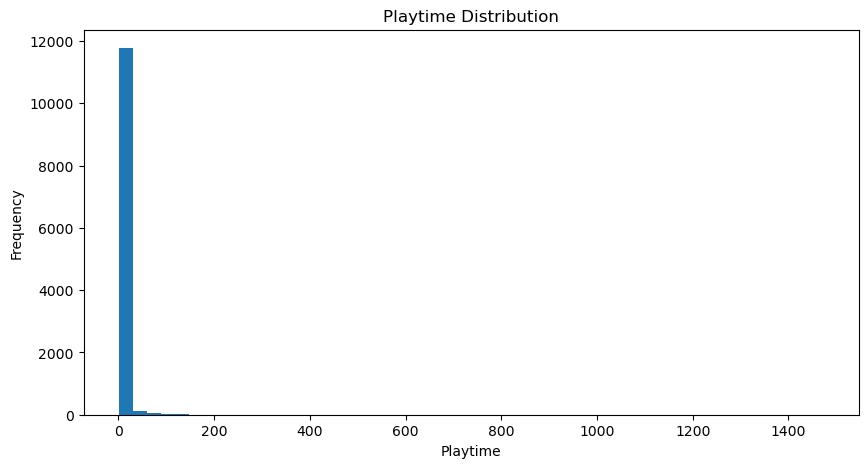

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df["playtime"].dropna(), bins=50)
plt.xlabel("Playtime")
plt.ylabel("Frequency")
plt.title("Playtime Distribution")
plt.show()


Original skew: 43.73500410411279
Transformed skew: 0.11022126271778385


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


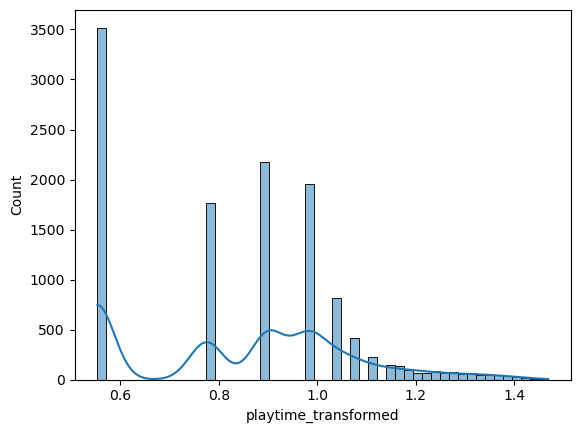

In [74]:
from scipy.stats import boxcox

# Ensure all values are positive
playtime = df['playtime'].astype(float) + 1  # add 1 if zeros exist

# Apply Box-Cox
df['playtime_transformed'], _ = boxcox(playtime)


# Check skewness
print("Original skew:", df['playtime'].skew())
print("Transformed skew:", df['playtime_transformed'].skew())
df = df.drop(columns=['playtime'])

sns.histplot(df['playtime_transformed'], bins=50, kde=True)
plt.show()


In [75]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

columns_to_encode = ["parent_platforms", "genres"]

for col in columns_to_encode:
    mlb = MultiLabelBinarizer()  # separate encoder for each column
    
    # Split multi-value strings into lists (e.g., "Action|RPG" → ["Action", "RPG"])
    df[col] = df[col].str.split('|')
    
    # Encode into one-hot DataFrame
    encoded = pd.DataFrame(
        mlb.fit_transform(df[col]),
        columns=[f"{col}_{c}" for c in mlb.classes_],
        index=df.index
    )
    
    # Concatenate encoded features and drop original column
    df = pd.concat([df.drop(columns=[col]), encoded], axis=1)


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11970 entries, 0 to 41791
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  11970 non-null  int64  
 1   slug                                11970 non-null  object 
 2   name                                11970 non-null  object 
 3   description                         11970 non-null  object 
 4   developers                          11970 non-null  object 
 5   tags                                11970 non-null  object 
 6   rating                              11970 non-null  float64
 7   ratings_count                       11970 non-null  float64
 8   reviews_count                       11970 non-null  float64
 9   added                               11970 non-null  float64
 10  released                            11970 non-null  object 
 11  background_image                    11970 non-

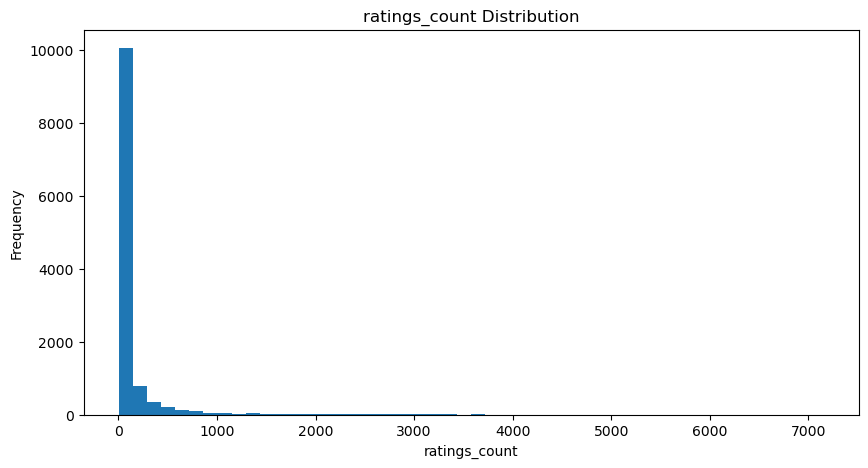

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df["ratings_count"].dropna(), bins=50)
plt.xlabel("ratings_count")
plt.ylabel("Frequency")
plt.title("ratings_count Distribution")
plt.show()


Original skew: 7.155469731836038
Transformed skew: 0.1733411090576805


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


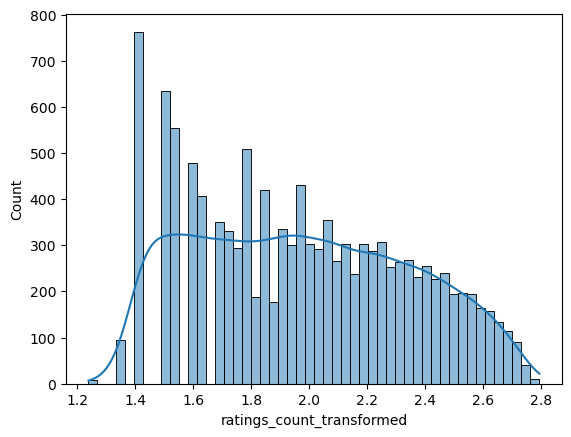

In [78]:
from scipy.stats import boxcox

# Ensure all values are positive
playtime = df['ratings_count'].astype(float) + 1  # add 1 if zeros exist

# Apply Box-Cox
df['ratings_count_transformed'], _ = boxcox(playtime)


# Check skewness
print("Original skew:", df['ratings_count'].skew())
print("Transformed skew:", df['ratings_count_transformed'].skew())
df = df.drop(columns=['ratings_count'])

sns.histplot(df['ratings_count_transformed'], bins=50, kde=True)
plt.show()


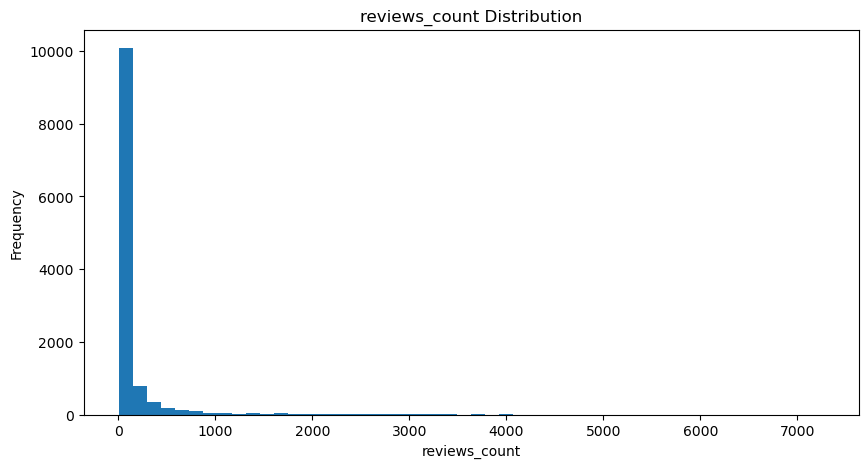

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df["reviews_count"].dropna(), bins=50)
plt.xlabel("reviews_count")
plt.ylabel("Frequency")
plt.title("reviews_count Distribution")
plt.show()


Original skew: 7.178012149833109
Transformed skew: 0.1764852755390386


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


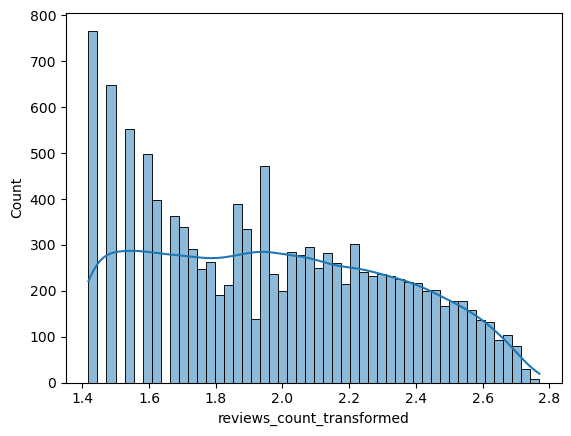

In [80]:
from scipy.stats import boxcox

# Ensure all values are positive
playtime = df['reviews_count'].astype(float) + 1  # add 1 if zeros exist

# Apply Box-Cox
df['reviews_count_transformed'], _ = boxcox(playtime)


# Check skewness
print("Original skew:", df['reviews_count'].skew())
print("Transformed skew:", df['reviews_count_transformed'].skew())
df = df.drop(columns=['reviews_count'])

sns.histplot(df['reviews_count_transformed'], bins=50, kde=True)
plt.show()


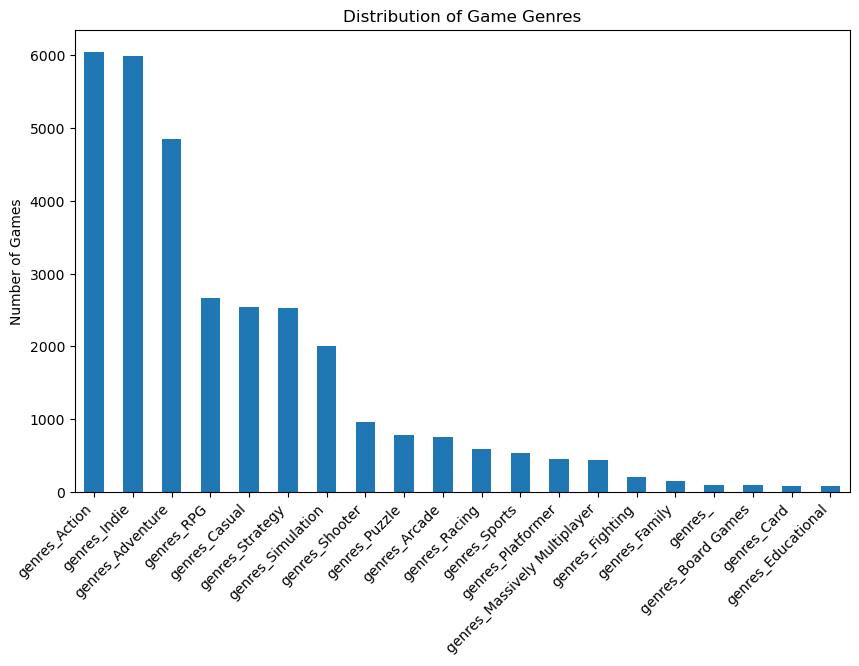

In [81]:
import matplotlib.pyplot as plt

# Sum each genre column (since 1 = presence)
genre_counts = df.filter(like="genres_").sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
genre_counts.plot(kind='bar')
plt.title("Distribution of Game Genres")
plt.ylabel("Number of Games")
plt.xticks(rotation=45, ha='right')
plt.show()


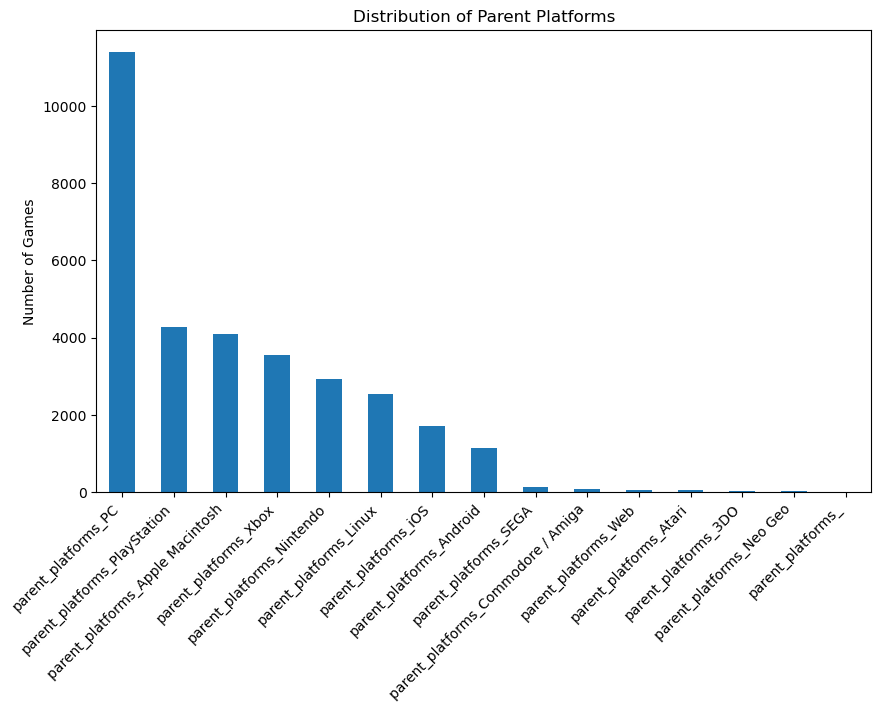

In [82]:
platform_counts = df.filter(like="parent_platforms_").sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
platform_counts.plot(kind='bar')
plt.title("Distribution of Parent Platforms")
plt.ylabel("Number of Games")
plt.xticks(rotation=45, ha='right')
plt.show()


Here we can see that more users use pc for gaming and also action games are the most favorite among gamers 

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Game Ratings')

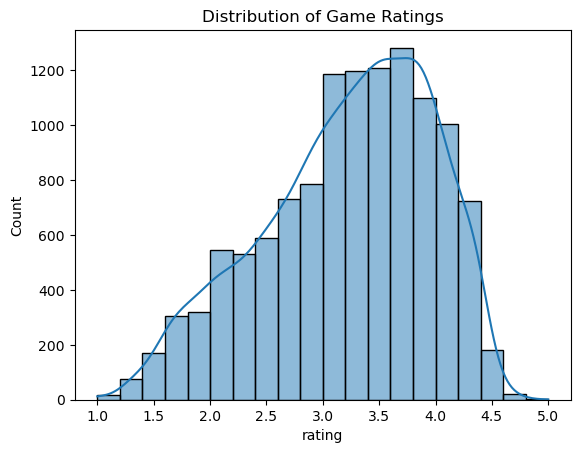

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribution of Game Ratings')


Text(0.5, 1.0, 'Ratings Count vs Average Rating')

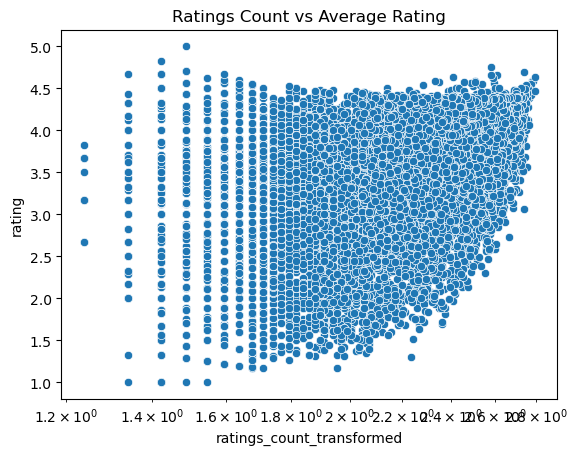

In [84]:
sns.scatterplot(data=df, x='ratings_count_transformed', y='rating')
plt.xscale('log')
plt.title('Ratings Count vs Average Rating')


<Axes: xlabel='reviews_count_transformed', ylabel='rating'>

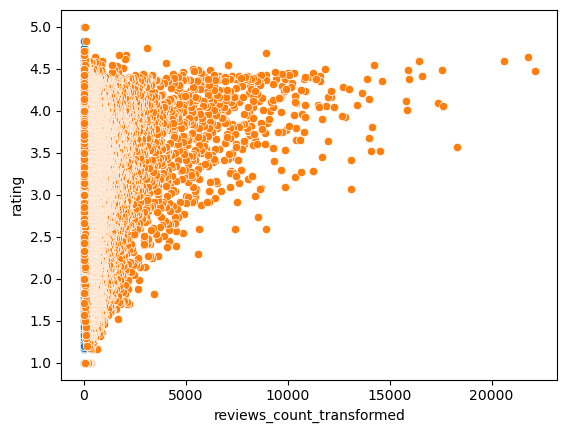

In [85]:
sns.scatterplot(data=df, x='reviews_count_transformed', y='rating')
sns.scatterplot(data=df, x='added', y='rating')


Here we can see when review and rating counts increase rating also increseas so rating they 

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


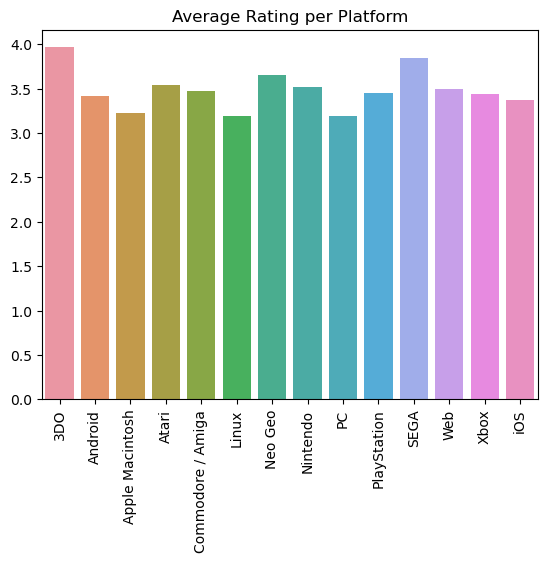

In [86]:
avg_rating = {
    col.replace('parent_platforms_', ''): df.loc[df[col] == 1, 'rating'].mean()
    for col in df.columns if col.startswith('parent_platforms_') and col != 'parent_platforms_'
}

sns.barplot(x=list(avg_rating.keys()), y=list(avg_rating.values()))
plt.xticks(rotation=90)
plt.title('Average Rating per Platform')
plt.show()


So games released in 3DO platform have the biggest ratings

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'Average Rating per Genre')

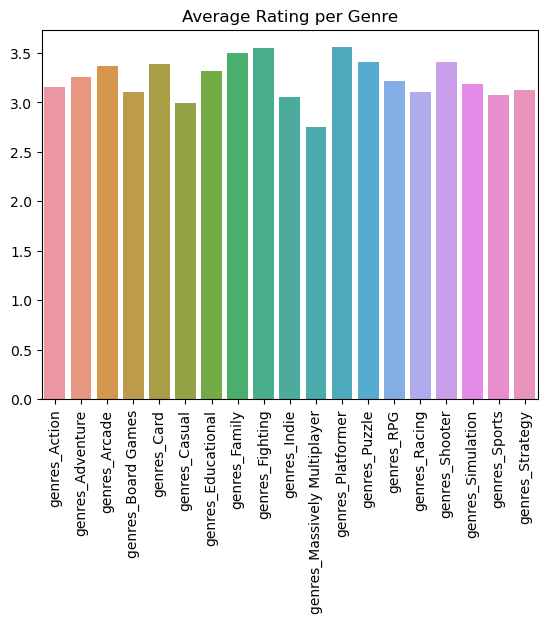

In [87]:
genre_cols = [col for col in df.columns if 'genres_' in col]
avg_rating_by_genre = {
    col: df.loc[df[col] == 1, 'rating'].mean()
    for col in genre_cols
    if col != 'genres_'
}
sns.barplot(x=list(avg_rating_by_genre.keys()), y=list(avg_rating_by_genre.values()))
plt.xticks(rotation=90)
plt.title('Average Rating per Genre')

Platformer genre are rated higher compared to other games

Text(0.5, 1.0, 'Correlation Matrix of Numeric Features')

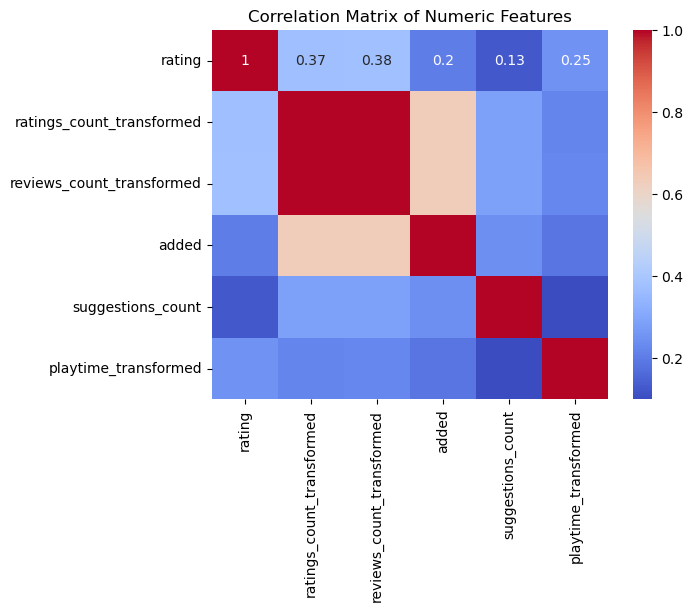

In [88]:
num_cols = ['rating', 'ratings_count_transformed', 'reviews_count_transformed', 'added', 
            'suggestions_count', 'playtime_transformed']
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')

In [89]:
corr_matrix = df.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df = df.drop(columns=to_drop)


Because review count was highly correlated we droped it

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11970 entries, 0 to 41791
Data columns (total 49 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  11970 non-null  int64  
 1   slug                                11970 non-null  object 
 2   name                                11970 non-null  object 
 3   description                         11970 non-null  object 
 4   developers                          11970 non-null  object 
 5   tags                                11970 non-null  object 
 6   rating                              11970 non-null  float64
 7   added                               11970 non-null  float64
 8   released                            11970 non-null  object 
 9   background_image                    11970 non-null  object 
 10  suggestions_count                   11970 non-null  float64
 11  clean_description                   11970 non-

In [91]:
# 1️⃣ Identify platform and genre columns
platform_cols = [col for col in df.columns if 'parent_platforms_' in col]
genre_cols = [col for col in df.columns if 'genres_' in col and col != 'genres_']

# 2️⃣ Get top 10 games by rating
top_games = df.sort_values(by='rating', ascending=False).head(10)

# 3️⃣ Function to extract platform/genre names for each row
def get_labels(row, cols, prefix):
    labels = [col.replace(prefix, '') for col in cols if row[col] == 1]
    return ' | '.join(labels) if labels else 'None'

# 4️⃣ Create new columns with readable platform and genre names
top_games = top_games.copy()  # avoid SettingWithCopyWarning
top_games['Platforms'] = top_games.apply(lambda row: get_labels(row, platform_cols, 'parent_platforms_'), axis=1)
top_games['Genres'] = top_games.apply(lambda row: get_labels(row, genre_cols, 'genres_'), axis=1)

# 5️⃣ Display final table
print(top_games[['name', 'rating', 'Platforms', 'Genres']].to_string(index=False))


                           name  rating                                    Platforms                              Genres
      Hazumi and the Pregnation    5.00                                           PC                         Indie | RPG
          ATRI -My Dear Moments    4.83                                           PC                  Adventure | Casual
                Persona 5 Royal    4.75           Nintendo | PC | PlayStation | Xbox                     Adventure | RPG
                    Micro Mages    4.71                                Nintendo | PC                      Action | Indie
    Red Rope: Don't Fall Behind    4.71                 Apple Macintosh | Linux | PC          Action | Adventure | Indie
Majesty: The Northern Expansion    4.71                                           PC                            Strategy
      The Last Of Us Remastered    4.69                                  PlayStation                  Action | Adventure
           Shoot Shoot My Waifu 

In [92]:
features = df.select_dtypes(include=[np.number])

scale = StandardScaler()
scaled_features = scale.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

scaled_features.head(5)

,id,rating,added,suggestions_count,playtime_transformed,parent_platforms_,parent_platforms_3DO,parent_platforms_Android,parent_platforms_Apple Macintosh,parent_platforms_Atari,...,genres_Massively Multiplayer,genres_Platformer,genres_Puzzle,genres_RPG,genres_Racing,genres_Shooter,genres_Simulation,genres_Sports,genres_Strategy,ratings_count_transformed
0,-0.482983,0.307753,6.619814,-0.488100,-1.293932,-0.018283,-0.034219,-0.323813,1.387781,-0.057173,...,-0.19604,-0.199234,-0.265643,-0.53491,-0.228911,-0.294449,-0.44923,-0.217146,-0.516657,1.890255
1,-0.512138,1.159978,10.138070,1.297679,1.432521,-0.018283,-0.034219,-0.323813,1.387781,-0.057173,...,-0.19604,-0.199234,-0.265643,-0.53491,-0.228911,3.396179,-0.44923,-0.217146,-0.516657,2.109068
2,-0.505898,1.692619,10.251205,-0.397394,0.604447,-0.018283,-0.034219,3.088199,1.387781,-0.057173,...,-0.19604,-0.199234,3.764453,-0.53491,-0.228911,-0.294449,-0.44923,-0.217146,-0.516657,2.169974
3,-0.548147,0.946922,7.302928,1.484761,2.005037,-0.018283,-0.034219,-0.323813,1.387781,-0.057173,...,-0.19604,-0.199234,-0.265643,-0.53491,4.368511,-0.294449,-0.44923,4.605192,-0.516657,2.078789
4,-0.547460,1.199926,9.148138,1.065244,1.054745,-0.018283,-0.034219,3.088199,1.387781,-0.057173,...,-0.19604,-0.199234,-0.265643,-0.53491,-0.228911,-0.294449,-0.44923,-0.217146,-0.516657,2.126360


In [93]:
model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute').fit(scaled_features)
print(model)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)


In [94]:
vg_distances, vg_indices = model.kneighbors(scaled_features)

print("List of indexes and distances for the first 5 games:\n")
print(vg_indices[:5], "\n")
print(vg_distances[:5])


List of indexes and distances for the first 5 games:

[[  0  66  64 176 281  40 164 193 461 423  29]
 [  1  29  10  31   5  18  83  19  33  13  82]
 [  2  13  55   4  24  31  47  38  21  16   6]
 [  3 236 541 569  47 861 219 130  24  21  39]
 [  4  23  28 196  77  31   6  21   2 172 126]] 

[[0.00000000e+00 2.60016115e-03 2.79622609e-03 3.29292233e-02
  6.93854753e-02 9.13528477e-02 1.19747401e-01 1.29531940e-01
  1.32223127e-01 1.33827846e-01 1.37771854e-01]
 [1.11022302e-16 2.52143954e-02 2.76064026e-02 4.77696471e-02
  4.93131800e-02 5.23199073e-02 5.34542988e-02 5.69116593e-02
  6.71186035e-02 7.04182703e-02 7.71235820e-02]
 [0.00000000e+00 1.09797552e-01 1.31002063e-01 1.45184912e-01
  1.45678297e-01 1.49289360e-01 1.52623139e-01 1.54014368e-01
  1.54023396e-01 1.63537554e-01 1.66294786e-01]
 [0.00000000e+00 1.42051273e-01 2.20945106e-01 2.28065164e-01
  2.48785578e-01 2.50699047e-01 2.63149869e-01 2.73006363e-01
  2.77080756e-01 2.90914517e-01 2.99801233e-01]
 [4.44089210e-16 8.9

In [95]:
game_names = df['name'].drop_duplicates()
game_names = game_names.reset_index(drop=True)

vectorizer = TfidfVectorizer(use_idf=True).fit(game_names)
print(vectorizer)

TfidfVectorizer()


In [96]:
game_title_vectors = vectorizer.transform(game_names)

print("List of game title vectors for the first 5 games:\n")
print(pd.DataFrame(game_title_vectors.toarray()).head(5))

List of game title vectors for the first 5 games:

   0     1     2     3     4     5     6     7     8     9     ...  9304  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   9305  9306  9307  9308  9309  9310  9311  9312  9313  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 9314 columns]


In [97]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import difflib

def _build_similarity_index(df_source, tfidf_matrix=None, n_neighbors=11, metric='cosine'):
    # 1. FEATURE SELECTION
    # REMOVED: 'ratings_count_transformed', 'playtime_transformed', 'suggestions_count'
    # REASON: These cause "Popularity Bias" (matching Minecraft with other famous but unrelated games).
    numeric_cols = [c for c in ['rating'] if c in df_source.columns]
    
    platform_cols = [c for c in df_source.columns if c.startswith('parent_platforms_')]
    genre_cols = [c for c in df_source.columns if c.startswith('genres_')]

    if not (numeric_cols or platform_cols or genre_cols):
        raise ValueError("No usable feature columns found.")

    # 2. PROCESS NUMERIC
    # We use a smaller scaler or just fillna because we reduced the weight heavily below.
    X_num = df_source[numeric_cols].fillna(0).values.astype(float) if numeric_cols else np.empty((len(df_source), 0))
    if numeric_cols:
        X_num = StandardScaler().fit_transform(X_num)

    # 3. PROCESS ONE-HOT (Genres/Platforms)
    X_oh_parts = []
    if platform_cols:
        X_oh_parts.append(df_source[platform_cols].fillna(0).values.astype(float))
    if genre_cols:
        X_oh_parts.append(df_source[genre_cols].fillna(0).values.astype(float))
    X_oh = np.hstack(X_oh_parts) if X_oh_parts else np.empty((len(df_source), 0))

    # 4. PROCESS TEXT (TF-IDF)
    if tfidf_matrix is not None:
        row_positions = df_source.index.values
        X_text = tfidf_matrix[row_positions].toarray()
    else:
        X_text = np.empty((len(df_source), 0))

    # 5. APPLY WEIGHTS (The Tuning)
    # Weight Hierarchy: Text (Mechanics) > Genre (Category) > Rating (Quality)
    weight_text = 2.0  # Increase this to prioritize gameplay description matches
    weight_oh = 0.3    # Keep this moderate
    weight_num = 0.5   # Keep this very low
    
    X = np.hstack([
        X_num * weight_num, 
        X_oh * weight_oh, 
        X_text * weight_text
    ])

    n_neighbors = min(n_neighbors, len(df_source))
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)

    return {
        'indices': indices,
        'distances': distances,
        'platform_cols': platform_cols,
        'genre_cols': genre_cols,
        'numeric_cols': numeric_cols
    }

def VideoGameTitleRecommender(title, df_local):
    choices = df_local['name'].astype(str).unique().tolist()
    matches = difflib.get_close_matches(title, choices, n=1, cutoff=0.5)
    return matches[0] if matches else None

def VideoGameRecommender(video_game_name, video_game_platform='Any', top_n=10):
    global df
    if 'df' not in globals():
        raise NameError("DataFrame 'df' not found. Load your dataset into variable 'df'.")

    platform_cols = [c for c in df.columns if c.startswith('parent_platforms_')]

    # filter DF to the platform first (this is the important fix)
    filtered_df = df.copy()
    platform_column = None
    if video_game_platform != 'Any':
        platform_column = f'parent_platforms_{video_game_platform}'
        if platform_column in df.columns:
            filtered_df = filtered_df[filtered_df[platform_column] == 1]
            if filtered_df.empty:
                print(f"No games found on platform '{video_game_platform}'.")
                return
        else:
            print(f"Platform '{video_game_platform}' not found in dataset.")
            return

    # find the requested game in filtered df
    candidate_rows = filtered_df[filtered_df['name'].astype(str) == str(video_game_name)]
    if candidate_rows.empty:
        # fallback: suggest closest match on platform
        suggestion = VideoGameTitleRecommender(video_game_name, filtered_df)
        if suggestion:
            print(f"'{video_game_name}' not found on this platform. Did you mean '{suggestion}'?")
        else:
            print(f"No match found for '{video_game_name}' on platform '{video_game_platform}'.")
        return

    # build index from platform-filtered DF
    index_data = _build_similarity_index(filtered_df, tfidf_matrix=tfidf_matrix, n_neighbors=min(11, len(filtered_df)))

    # find neighbors of the first match
    target_idx = candidate_rows.index[0]
    pos_in_filtered = filtered_df.index.get_loc(target_idx)

    neighbors = index_data['indices'][pos_in_filtered][1: top_n+1]
    recs = filtered_df.iloc[neighbors].copy()

    # Platforms & Genres display
    if platform_cols:
        recs['Platforms'] = recs[platform_cols].apply(
            lambda row: ' | '.join([c.replace('parent_platforms_', '') for c in platform_cols if row[c] == 1]),
            axis=1
        )
    else:
        recs['Platforms'] = ''

    genre_cols = [c for c in df.columns if c.startswith('genres_')]
    if genre_cols:
        recs['Genres'] = recs[genre_cols].apply(
            lambda row: ' | '.join([c.replace('genres_', '') for c in genre_cols if row[c] == 1]),
            axis=1
        )
    else:
        recs['Genres'] = ''

    # columns to display
    cols = ['name','rating']
    if 'ratings_count_transformed' in recs.columns:
        cols.append('ratings_count_transformed')
    elif 'ratings_count' in recs.columns:
        cols.append('ratings_count')
    cols += ['Platforms','Genres']

    print(f"Top {len(recs)} Recommended Games for '{video_game_name}' on {video_game_platform}")
    display(recs[cols].reset_index(drop=True))


In [98]:
df = df.reset_index(drop=True)

In [99]:
VideoGameRecommender("Minecraft", "Apple Macintosh")


Top 10 Recommended Games for 'Minecraft' on Apple Macintosh


,name,rating,ratings_count_transformed,Platforms,Genres
0,Terraria,4.07,2.729228,Android | Apple Macintosh | Linux | Nintendo |...,Action | Indie | Platformer
1,TerraTech,3.88,2.061187,Apple Macintosh | Linux | Nintendo | PC | Play...,Action | Indie | Strategy
2,LEGO Batman 2 DC Super Heroes,3.68,2.539192,Android | Apple Macintosh | Nintendo | PC | Pl...,Action | Family
3,DYSMANTLE,3.86,2.195031,Apple Macintosh | Linux | Nintendo | PC | Xbox...,Action | Adventure | Indie | RPG | Simulation
4,Don't Starve,3.85,2.667394,Apple Macintosh | Linux | Nintendo | PC | Play...,Indie
5,The Long Dark,3.91,2.641552,Apple Macintosh | Linux | Nintendo | PC | Play...,Action | Adventure | Indie | Simulation
6,LEGO Star Wars - The Complete Saga,4.10,2.608572,Android | Apple Macintosh | Nintendo | PC | Pl...,Action | Adventure
7,Dead Cells,4.24,2.702745,Apple Macintosh | Linux | Nintendo | PC | Play...,Action | Indie | Platformer | RPG
8,Sid Meier’s Civilization VI,4.16,2.686663,Apple Macintosh | Linux | Nintendo | PC | Play...,Simulation | Strategy
9,Pixel Survival - Craft Game,4.36,1.676447,Apple Macintosh | Linux | PC,Action | Adventure | Casual | Indie | Massivel...


In [100]:
VideoGameRecommender("Minecraft", "Nintendo")


Top 10 Recommended Games for 'Minecraft' on Nintendo


,name,rating,ratings_count_transformed,Platforms,Genres
0,Terraria,4.07,2.729228,Android | Apple Macintosh | Linux | Nintendo |...,Action | Indie | Platformer
1,TerraTech,3.88,2.061187,Apple Macintosh | Linux | Nintendo | PC | Play...,Action | Indie | Strategy
2,DYSMANTLE,3.86,2.195031,Apple Macintosh | Linux | Nintendo | PC | Xbox...,Action | Adventure | Indie | RPG | Simulation
3,LEGO Batman 2 DC Super Heroes,3.68,2.539192,Android | Apple Macintosh | Nintendo | PC | Pl...,Action | Family
4,Don't Starve,3.85,2.667394,Apple Macintosh | Linux | Nintendo | PC | Play...,Indie
5,LEGO Star Wars - The Complete Saga,4.10,2.608572,Android | Apple Macintosh | Nintendo | PC | Pl...,Action | Adventure
6,The Long Dark,3.91,2.641552,Apple Macintosh | Linux | Nintendo | PC | Play...,Action | Adventure | Indie | Simulation
7,Dead Cells,4.24,2.702745,Apple Macintosh | Linux | Nintendo | PC | Play...,Action | Indie | Platformer | RPG
8,Sid Meier’s Civilization VI,4.16,2.686663,Apple Macintosh | Linux | Nintendo | PC | Play...,Simulation | Strategy
9,Stardew Valley,4.40,2.728587,Android | Apple Macintosh | Linux | Nintendo |...,Indie | RPG | Simulation


In [101]:
VideoGameRecommender("Minecraft")

Top 10 Recommended Games for 'Minecraft' on Any


,name,rating,ratings_count_transformed,Platforms,Genres
0,Until Then,4.25,1.546805,Linux | PC | PlayStation,Adventure | Casual | Indie
1,Touhou Project 東方天空璋 ～ Hidden Star in Four Sea...,4.14,1.422674,PC,Indie
2,Terraria,4.07,2.729228,Android | Apple Macintosh | Linux | Nintendo |...,Action | Indie | Platformer
3,TerraTech,3.88,2.061187,Apple Macintosh | Linux | Nintendo | PC | Play...,Action | Indie | Strategy
4,LEGO Batman 2 DC Super Heroes,3.68,2.539192,Android | Apple Macintosh | Nintendo | PC | Pl...,Action | Family
5,DYSMANTLE,3.86,2.195031,Apple Macintosh | Linux | Nintendo | PC | Xbox...,Action | Adventure | Indie | RPG | Simulation
6,Don't Starve,3.85,2.667394,Apple Macintosh | Linux | Nintendo | PC | Play...,Indie
7,GuJian 古剑奇谭,4.00,1.489950,PC,RPG
8,The Long Dark,3.91,2.641552,Apple Macintosh | Linux | Nintendo | PC | Play...,Action | Adventure | Indie | Simulation
9,LEGO Star Wars - The Complete Saga,4.10,2.608572,Android | Apple Macintosh | Nintendo | PC | Pl...,Action | Adventure


In [102]:
VideoGameRecommender('Call of Duty: World at War')

Top 10 Recommended Games for 'Call of Duty: World at War' on Any


,name,rating,ratings_count_transformed,Platforms,Genres
0,Call of Duty: WWII,3.54,2.670570,PC | PlayStation | Xbox,Action | Shooter
1,Wolfenstein II: The New Colossus,4.10,2.704850,Nintendo | PC | PlayStation | Xbox,Action | Shooter
2,Battle of Empires: 1914-1918,3.92,1.710316,Apple Macintosh | Linux | PC,Action | Strategy
3,Call of Duty: Black Ops,4.05,2.708553,Apple Macintosh | Nintendo | PC | PlayStation ...,Action | Shooter
4,Commandos 2: Men of Courage,4.22,2.466665,PC | PlayStation | Xbox,Action
5,Wolfenstein: The Old Blood,4.00,2.667880,PC | PlayStation | Xbox,Action | Shooter
6,Call of Duty: Vanguard,3.10,2.377827,PC | PlayStation | Xbox,Shooter
7,Sniper Elite 4,3.58,2.624916,Nintendo | PC | PlayStation | Xbox,Action | Adventure | Shooter
8,Call of Duty: Black Ops II,3.96,2.687086,Nintendo | PC | PlayStation | Xbox,Action | Shooter
9,Call of Duty,4.16,2.646737,Apple Macintosh | PC | PlayStation | Xbox,Shooter


In [103]:
import joblib
import pandas as pd

# The dataframe 'df' should be the one after all your cleaning and processing
# The 'model' should be your trained NearestNeighbors model

# Save the processed dataframe
df.to_pickle("processed_new_df.pkl")

# Save the k-NN model
joblib.dump(model, "knn_model_final.joblib")

['knn_model_final.joblib']

In [104]:
import joblib

# Replace 'features' with the name of your scaled dataframe or matrix variable
# In your app.py, the code expects this to be a pandas DataFrame or similar object
joblib.dump(features, "scaled_features.pkl")

['scaled_features.pkl']

In [105]:
scaled_features.to_csv("scaled_features.csv", index=False)


In [106]:
import scipy.sparse as sp
import joblib

# 1. Define Weights (Matching your Notebook's logic)
W_NUM = 0.5  # Low weight for numeric stats
W_CAT = 0.3  # Medium weight for Genre/Platform
W_TXT = 2.0  # High weight for Description text

# 2. Prepare Numeric Data
# We only use 'rating' to avoid popularity bias (as seen in your notebook comments)
numeric_cols = ['rating'] 
X_num = df[numeric_cols].fillna(0).values
X_num_scaled = StandardScaler().fit_transform(X_num) * W_NUM

# 3. Prepare Categorical Data (One-Hot)
# Select platform and genre columns
platform_cols = [c for c in df.columns if 'parent_platforms_' in c]
genre_cols = [c for c in df.columns if 'genres_' in c]
cat_cols = platform_cols + genre_cols

X_cat = df[cat_cols].fillna(0).values * W_CAT

# 4. Prepare Text Data (TF-IDF)
# Assuming 'tfidf_matrix' was created in Cell 70
X_text = tfidf_matrix * W_TXT

# 5. Combine into one sparse matrix (Efficient for memory)
X_final = sp.hstack([
    sp.csr_matrix(X_num_scaled),
    sp.csr_matrix(X_cat),
    X_text
], format='csr')

# 6. Fit the Model on this FULL matrix
model_final = NearestNeighbors(n_neighbors=50, metric='cosine', algorithm='brute')
model_final.fit(X_final)

# 7. Save the files for the App
print("Saving artifacts...")
joblib.dump(model_final, "knn_model_final.joblib")
joblib.dump(X_final, "weighted_features.joblib") 
df.to_pickle("processed_df.pkl")
print("Done! Move 'weighted_features.joblib', 'knn_model_final.joblib', and 'processed_df.pkl' to your app folder.")


Saving artifacts...
Done! Move 'weighted_features.joblib', 'knn_model_final.joblib', and 'processed_df.pkl' to your app folder.
